<a href="https://colab.research.google.com/github/aureliosaraiva/ia-test/blob/main/Detectar_Tumores.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import kagglehub
import os
import random
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import torch
import torch.nn as nn
from torch.optim import Adam
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import torchvision.transforms.functional as TF

In [3]:
path = kagglehub.dataset_download("fanconic/skin-cancer-malignant-vs-benign")

100%|██████████| 325M/325M [00:02<00:00, 127MB/s]

Extracting files...


In [4]:
def count_files(directory):
    categories = os.listdir(directory)
    total_per_category = {}

    for category in categories:
        category_path = os.path.join(directory, category)
        if os.path.isdir(category_path):
            total_files = len(os.listdir(category_path))
            total_per_category[category] = total_files

    return total_per_category

train_directory = os.path.join(path, "train")
test_directory = os.path.join(path, "test")

total_train = count_files(train_directory)
total_test = count_files(test_directory)

print("Total files in the training folder by category:", total_train)
print("Total files in the test folder by category:", total_test)

Total files in the training folder by category: {'benign': 1440, 'malignant': 1197}
Total files in the test folder by category: {'benign': 360, 'malignant': 300}


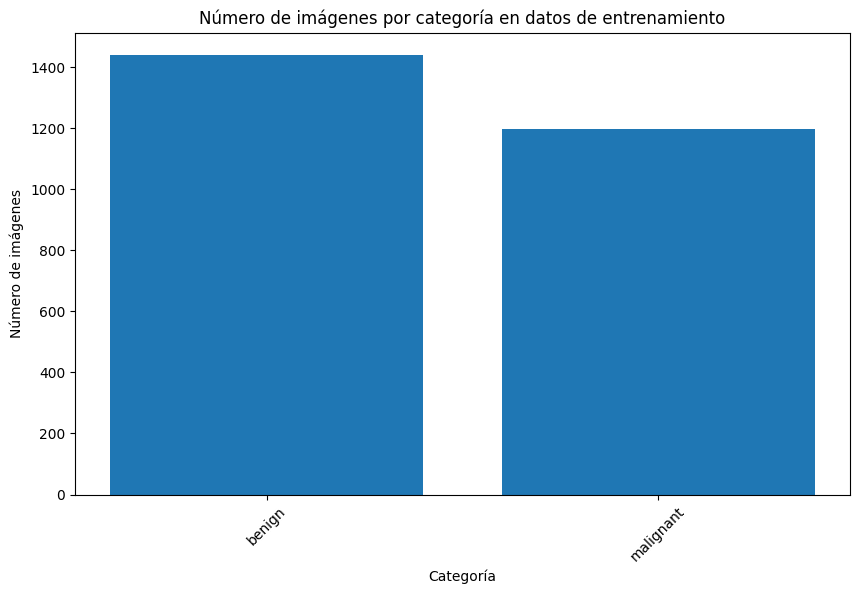

In [11]:
categories = list(total_train.keys())
file_counts = list(total_train.values())

plt.figure(figsize=(10, 6))
plt.bar(categories, file_counts)
plt.xlabel("Categoría")
plt.ylabel("Número de imágenes")
plt.title("Número de imágenes por categoría en datos de entrenamiento")
plt.xticks(rotation=45)
plt.show()

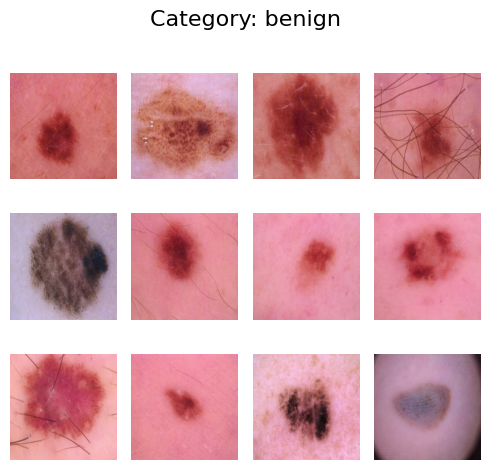

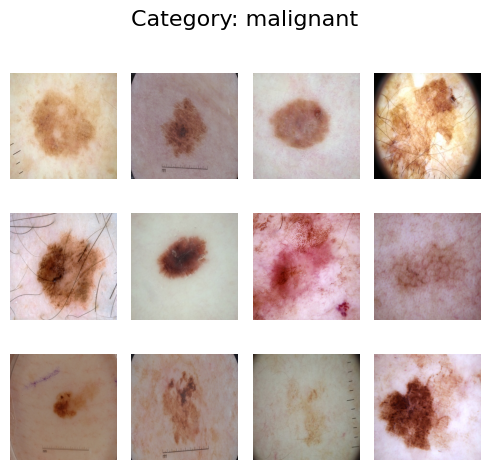

In [6]:
def display_images_grid(directory, num_images=12):
    categories = os.listdir(directory)
    for category in categories:
        category_path = os.path.join(directory, category)
        if os.path.isdir(category_path):
            images = os.listdir(category_path)
            samples = random.sample(images, min(num_images, len(images)))

            fig, axes = plt.subplots(3, 4, figsize=(5, 5))
            fig.suptitle(f"Category: {category}", fontsize=16)

            for i, image_name in enumerate(samples):
                row, col = divmod(i, 4)
                image_path = os.path.join(category_path, image_name)
                image = Image.open(image_path)
                axes[row, col].imshow(image)
                axes[row, col].axis("off")

            plt.tight_layout()
            plt.subplots_adjust(top=0.9)
            plt.show()

train_directory = os.path.join(path, "train")

display_images_grid(train_directory)

In [7]:
# Define a transformation pipeline with data augmentation
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # Randomly crop and resize images
    transforms.RandomHorizontalFlip(),                    # Apply random horizontal flip
    transforms.RandomRotation(30),                        # Randomly rotate images by ±30 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Random color jitter
    transforms.ToTensor(),                                # Convert image to PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize based on ImageNet standards
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Redimensiona para o formato esperado pelo modelo
    transforms.ToTensor(),  # Converte para Tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalização
])

# Carregar os datasets
train_dataset = datasets.ImageFolder(root=f"{path}/train", transform=train_transforms)
test_dataset = datasets.ImageFolder(root=f"{path}/test", transform=test_transforms)

# DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Classes
print("Classes disponíveis:", train_dataset.classes)



Classes disponíveis: ['benign', 'malignant']


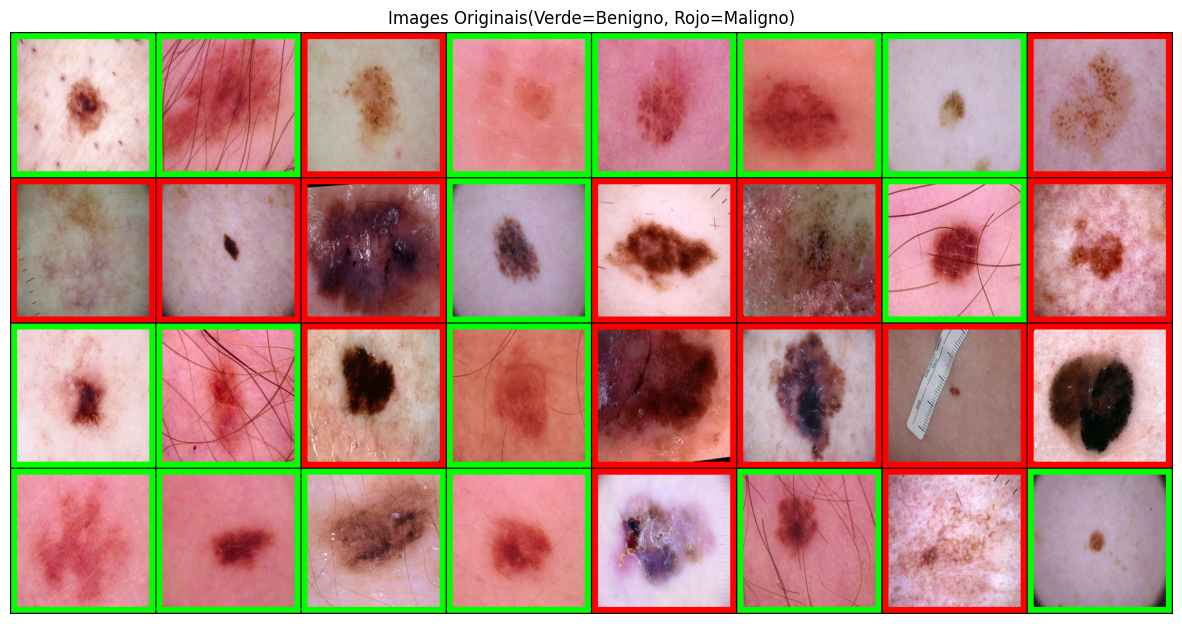

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageOps
from torchvision.utils import make_grid

# Função para adicionar borda
def add_border(image, label, border_size=10):
    """
    Adiciona uma borda colorida à imagem baseada no rótulo.
    - Verde para benigno (label=0).
    - Vermelho para maligno (label=1).
    """
    color = (0, 255, 0) if label == 0 else (255, 0, 0)  # Verde ou Vermelho
    bordered_image = ImageOps.expand(image, border=border_size, fill=color)
    return bordered_image

# Remova transformações de normalização ou ajuste para o loader usado para visualização
train_transforms_visual = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()  # Sem normalizar
])

# Loader visual (separado, para evitar impacto no treinamento)
train_dataset_visual = datasets.ImageFolder(root=f"{path}/train", transform=train_transforms_visual)
train_loader_visual = DataLoader(train_dataset_visual, batch_size=32, shuffle=True)

# Obter um batch do DataLoader
dataiter = iter(train_loader_visual)
images, labels = next(dataiter)

# Processar as imagens originais
original_images_with_borders = []
for image, label in zip(images, labels):
    # Converte de Tensor para PIL e aplica a borda
    image_pil = TF.to_pil_image(image)
    bordered_image = add_border(image_pil, label)
    original_images_with_borders.append(TF.to_tensor(bordered_image))  # Volta ao formato Tensor

# Criar grid
grid = make_grid(original_images_with_borders, nrow=8, padding=2)

# Exibir o grid
plt.figure(figsize=(15, 8))
plt.imshow(np.transpose(grid.numpy(), (1, 2, 0)))
plt.axis('off')```````
plt.title("Images Originais(Verde=Benigno, Rojo=Maligno)")
plt.show()


In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

# Modelo pretreinado (ResNet)
model = models.resnet18(pretrained=True)

# Congelar as camadas convolucionais
for param in model.parameters():
    param.requires_grad = False

# Substituir a camada linear final
num_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_features, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, 1),  # Binário: 1 saída
    nn.Sigmoid()  # Sigmoid para classificação binária
)
model.to(device)

Usando dispositivo: cuda


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 150MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [14]:
# Configuração para treinamento
criterion = nn.BCELoss()  # Função de perda binária
optimizer = Adam(model.fc.parameters(), lr=0.001)

# Função de treinamento
def train_model(model, train_loader, criterion, optimizer, device):
    model.train()  # Modo de treinamento
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device).float()

        optimizer.zero_grad()
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    return running_loss / len(train_loader)

def evaluate_model(model, test_loader, criterion, device):
    model.eval()  # Modo de avaliação
    test_loss = 0.0
    preds = []
    targets = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device).float()
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            preds.extend((outputs > 0.5).cpu().numpy())
            targets.extend(labels.cpu().numpy())
    accuracy = accuracy_score(targets, preds)
    return test_loss / len(test_loader), accuracy

In [15]:
epochs = 10
train_losses = []
test_losses = []
accuracies = []

for epoch in range(epochs):
    # Train
    train_loss = train_model(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)

    # Test
    test_loss, accuracy = evaluate_model(model, test_loader, criterion, device)
    test_losses.append(test_loss)
    accuracies.append(accuracy)

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.4f}")


Epoch 1/10, Train Loss: 0.5071, Test Loss: 0.4763, Accuracy: 0.8015
Epoch 2/10, Train Loss: 0.4294, Test Loss: 0.4027, Accuracy: 0.8106
Epoch 3/10, Train Loss: 0.4206, Test Loss: 0.3964, Accuracy: 0.8197
Epoch 4/10, Train Loss: 0.4206, Test Loss: 0.4385, Accuracy: 0.8030
Epoch 5/10, Train Loss: 0.3925, Test Loss: 0.3733, Accuracy: 0.8258
Epoch 6/10, Train Loss: 0.3935, Test Loss: 0.3644, Accuracy: 0.8303
Epoch 7/10, Train Loss: 0.3941, Test Loss: 0.3522, Accuracy: 0.8379
Epoch 8/10, Train Loss: 0.4011, Test Loss: 0.3765, Accuracy: 0.8273
Epoch 9/10, Train Loss: 0.3900, Test Loss: 0.3551, Accuracy: 0.8273
Epoch 10/10, Train Loss: 0.3672, Test Loss: 0.3609, Accuracy: 0.8258


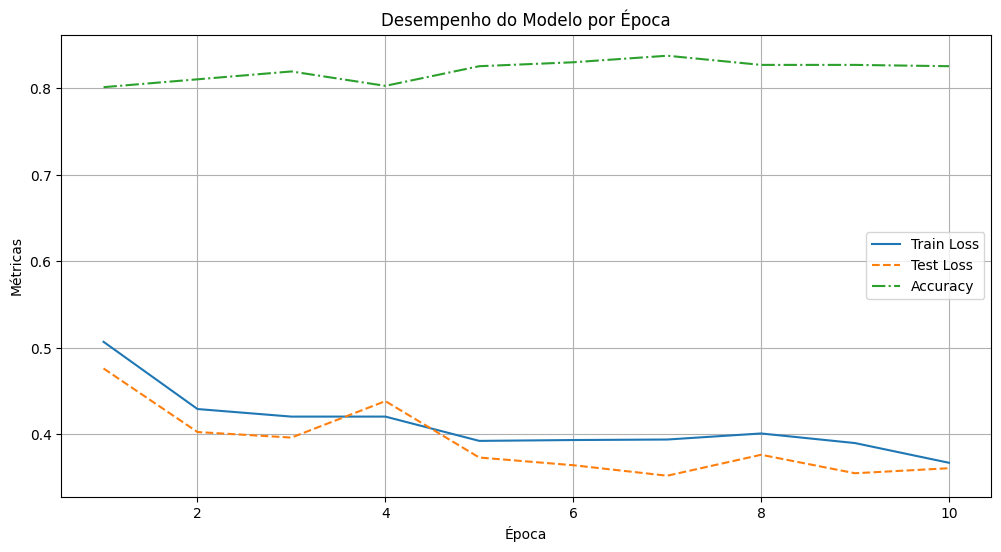

In [16]:
# Gráfico final
plt.figure(figsize=(12, 6))
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, epochs + 1), test_losses, label='Test Loss', linestyle='--')
plt.plot(range(1, epochs + 1), accuracies, label='Accuracy', linestyle='-.')
plt.xlabel('Época')
plt.ylabel('Métricas')
plt.title('Desempenho do Modelo por Época')
plt.legend()
plt.grid(True)
plt.show()

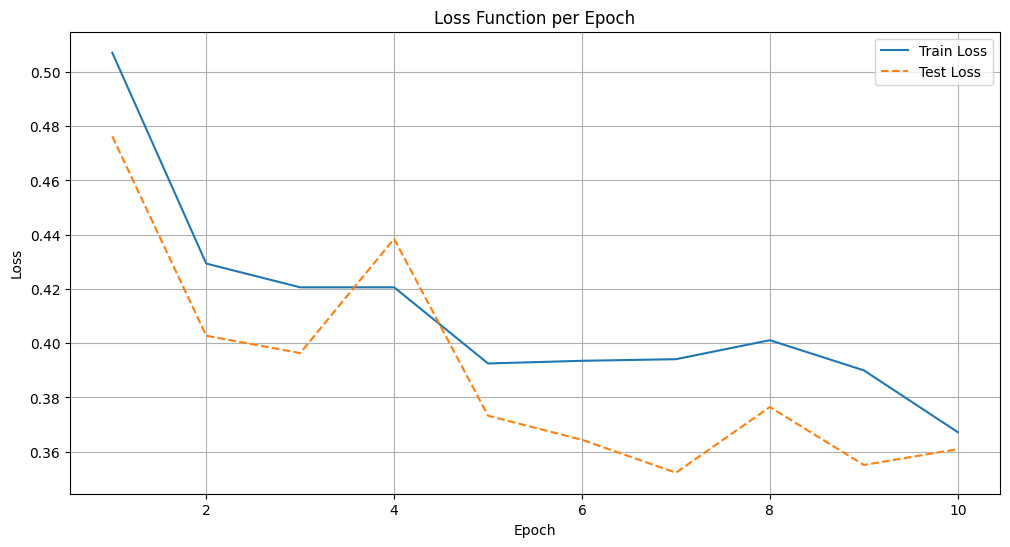

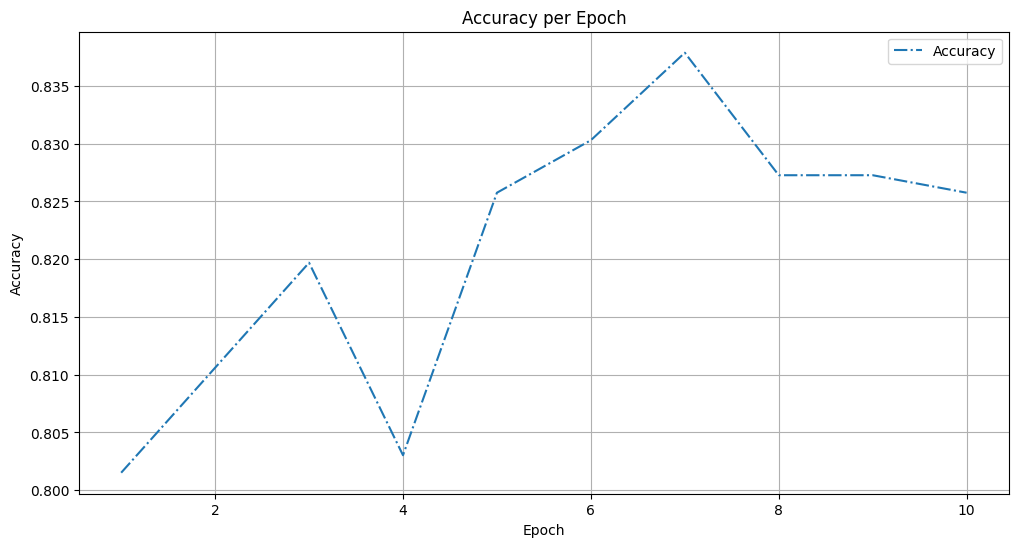

In [17]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, epochs + 1), test_losses, label='Test Loss', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Function per Epoch')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(range(1, epochs + 1), accuracies, label='Accuracy', linestyle='-.')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy per Epoch')
plt.legend()
plt.grid(True)
plt.show()